# Analyze eye signal data

created: November 19, 2024 <br>
last modified:  February 28, 2024

Start by analyzing a downsampled version of eye data, then introduce full resolution eye data and compare resting state aperiodic activity in eyes open vs close and in specific timepoint when eyes closed become open (or viceversa)

In [1]:
# Imports
import neo
import numpy as np
import pandas as pd
import quantities as pq
import matplotlib.pyplot as plt
from mne.time_frequency import psd_array_multitaper

# custom
import sys
sys.path.append("../../code")
from info import FS
from settings import N_JOBS
from paths import EXTERNAL_PATH
from utils import load_nix, epoch_neo_segment

In [2]:
# set path
eye_path = EXTERNAL_PATH + "/V1_v4_1024_electrode_resting_state_data/data/L_RS_090817/eye_signals/"

lfp_path = EXTERNAL_PATH + "/V1_v4_1024_electrode_resting_state_data/data/L_RS_090817/LFP/"

### Analyze eye data
Create new nix file containing behavioral states

In [17]:
# Load data
with neo.NixIO(eye_path + "aligned_eye_data.nix", mode='ro') as nio:
    eye_block = nio.read_block()

eye_block

Block with 1 segments
name: 'Eye signals'
description: 'eye position and diameters'
annotations: {'nix_name': 'neo.block.4296992d060d4ee7b15db59fadc15740'}
file_datetime: datetime.datetime(2021, 4, 19, 13, 5, 17, 913450)
rec_datetime: datetime.datetime(2021, 4, 19, 6, 25, 32)
# segments (N=1)
0: Segment with 4 analogsignals, 1 epochs
   name: 'eye signal segment'
   description: 'Segment of eye pos and diam'
   annotations: {'nix_name': 'neo.segment.c532f30c3a734eabae2418c49282dada'}
   # analogsignals (N=4)
   0: AnalogSignal with 1 channels of length 39627730; units mV; datatype int16 
      name: 'XPos'
      annotations: {'nix_name': 'neo.analogsignal.19582fa74cef491f8a907698b6ad6702'}
      sampling rate: 30000.0 Hz
      time: 0.0 s to 1320.9243333333334 s
   1: AnalogSignal with 1 channels of length 39627730; units mV; datatype int16 
      name: 'YPos'
      annotations: {'nix_name': 'neo.analogsignal.62564a856339447fa99eb204ee0daddc'}
      sampling rate: 30000.0 Hz
      time

In [18]:
# set datetime to None to avoid errors when saving
# Neo Github issue: https://github.com/NeuralEnsemble/python-neo/issues/1198

print(f"Original datetime: {eye_block.rec_datetime}")

# set block and segment datetime to None
eye_block.rec_datetime = None
for segment in eye_block.segments:
    segment.rec_datetime = None

print(f"New datetime: {eye_block.rec_datetime}")


Original datetime: 2021-04-19 06:25:32
New datetime: None


In [19]:
# access X and Y pupil diameter
xdiam = eye_block.segments[0].analogsignals[2] / 1000
ydiam = eye_block.segments[0].analogsignals[3] / 1000
xdiam[xdiam < 0] = 0*pq.mV
ydiam[ydiam < 0] = 0*pq.mV

# we use .magnitude to access values
diam = np.sqrt(ydiam.magnitude**2 + xdiam.magnitude**2)
print(f"pupil diameter for every time point: {diam.shape}")

pupil diameter for every time point: (39627730, 1)


In [20]:
### Estimate behavioural epochs

# Empirically estimated thresholds for eye closure, according to Chen et al
#   if 'L_RS_090817' in eye_path: thr = 0.101
mask = (diam > 0.101)
behavioral_state = mask.astype(float)[:, 0]

# Smoothen states with sliding window
w = 3
kernel = [1/w]*w
behavioral_state = np.convolve(behavioral_state, kernel, mode='same')
behavioral_state[behavioral_state < 0.5] = 0
behavioral_state[behavioral_state >= 0.5] = 1

# Save signal to block
behaviour_anasig = neo.core.AnalogSignal(behavioral_state,
                                              units=pq.V,
                                              sampling_rate=xdiam.sampling_rate,
                                              name='Behavioural state')
eye_block.segments[0].analogsignals.append(behaviour_anasig)

In [7]:
unique, counts = np.unique(behavioral_state, return_counts=True)
print(f"Eyes open or closed measured in binary: {unique} \neyes closed: {counts[0]} \neyes open:{counts[1]}")

Eyes open or closed measured in binary: [0. 1.] 
eyes closed: 32473667 
eyes open:7154063


In [ ]:
# confirm that we have 5 analogsignals (our 4 original + behaviour)
eye_block.segments[0]

Segment with 5 analogsignals, 1 epochs
name: 'eye signal segment'
description: 'Segment of eye pos and diam'
annotations: {'nix_name': 'neo.segment.c532f30c3a734eabae2418c49282dada'}
# analogsignals (N=5)
0: AnalogSignal with 1 channels of length 39627730; units mV; datatype int16 
   name: 'XPos'
   annotations: {'nix_name': 'neo.analogsignal.19582fa74cef491f8a907698b6ad6702'}
   sampling rate: 30000.0 Hz
   time: 0.0 s to 1320.9243333333334 s
1: AnalogSignal with 1 channels of length 39627730; units mV; datatype int16 
   name: 'YPos'
   annotations: {'nix_name': 'neo.analogsignal.62564a856339447fa99eb204ee0daddc'}
   sampling rate: 30000.0 Hz
   time: 0.0 s to 1320.9243333333334 s
2: AnalogSignal with 1 channels of length 39627730; units mV; datatype int16 
   name: 'XDiam'
   annotations: {'nix_name': 'neo.analogsignal.6ec6601136fb4b00be8f79bbf5e4ad78'}
   sampling rate: 30000.0 Hz
   time: 0.0 s to 1320.9243333333334 s
3: AnalogSignal with 1 channels of length 39627730; units mV; 

In [25]:
# save file 
with neo.io.NixIO(eye_path + "L_RS_090817_aligned_eye_data.nix", mode='ow') as nio:
    nio.write_block(eye_block)

print(f"Block saved to {eye_path}L_RS_090817_aligned_eye_data.nix")

Block saved to E:/V1_v4_1024_electrode_resting_state_data/data/L_RS_090817/eye_signals/L_RS_090817_aligned_eye_data.nix


## Plot time windows and load LFP data

In [3]:
# load LFP and eye data 
fname = lfp_path + "NSP1_array1_LFP.nix"
lfp_segment, _ = load_nix(fname)
lfp_signal = lfp_segment.analogsignals[0]

with neo.io.NixIO(eye_path + "L_RS_090817_aligned_eye_data.nix", mode='ro') as nio:
    eye_block = nio.read_block()
eye_signal = eye_block.segments[0].analogsignals[4]

# # downsample eye signals to fit LFP
# downsample_factor = int(pre_eye_signal.sampling_rate.magnitude / lfp_signal.sampling_rate.magnitude)
# if downsample_factor == 60 :
#     eye_signal = pre_eye_signal.downsample(downsample_factor)

# if len(eye_signal) == len(lfp_signal):
#     print(f"Total values in signal: {len(lfp_signal)}")

In [4]:
print(f"Segment duration: {lfp_segment.t_start} to {lfp_segment.t_stop}")

Segment duration: 0.0 s to 1320.926 s


In [5]:
# time indices where there is a change from eyes open to eyes closed
eye_array = eye_signal.magnitude.flatten()
wh = np.where(np.diff(eye_array) != 0)[0]
print(f"Number of changes in behavioral states: {wh.shape[0]} \nTotal time points: {eye_array.shape[0]}")

Number of changes in behavioral states: 1102 
Total time points: 39627730


In [6]:
# find instances where the eyes are open/closed for 1sec duration and then 1sec of the other state
DURATION = 1 # in seconds 
differences = np.diff(wh)

epoch_times = np.array([])
for i in np.where(differences >= DURATION*30000)[0]:
    epoch_times = np.append(wh[i], epoch_times)

epoch_times = np.sort(epoch_times)
#epoch_times
print(f"Number of changes in behavioral states with {DURATION} seconds: {epoch_times.shape[0]}")

Number of changes in behavioral states with 1 seconds: 126


In [61]:
np.arange(0.5,6.5,0.5)

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ])

In [13]:
DURATION_TIMES = np.arange(0.5,6.5,0.5)

instances = np.array([])

for t in DURATION_TIMES:
    DURATION = t # in seconds 
    differences = np.diff(wh)

    epoch_times = np.array([])
    for i in np.where(differences >= DURATION*30000)[0]:
        epoch_times = np.append(wh[i], epoch_times)

    epoch_times = np.sort(epoch_times)
    instances = np.append(instances, epoch_times.shape[0])

    #epoch_times
    print(f"Number of changes in behavioral states with {DURATION} seconds: {epoch_times.shape[0]}")
        

Number of changes in behavioral states with 0.5 seconds: 170
Number of changes in behavioral states with 1.0 seconds: 126
Number of changes in behavioral states with 1.5 seconds: 93
Number of changes in behavioral states with 2.0 seconds: 79
Number of changes in behavioral states with 2.5 seconds: 65
Number of changes in behavioral states with 3.0 seconds: 54
Number of changes in behavioral states with 3.5 seconds: 46
Number of changes in behavioral states with 4.0 seconds: 38
Number of changes in behavioral states with 4.5 seconds: 31
Number of changes in behavioral states with 5.0 seconds: 27
Number of changes in behavioral states with 5.5 seconds: 26
Number of changes in behavioral states with 6.0 seconds: 24


Text(0, 0.5, 'Number of changes in behavior')

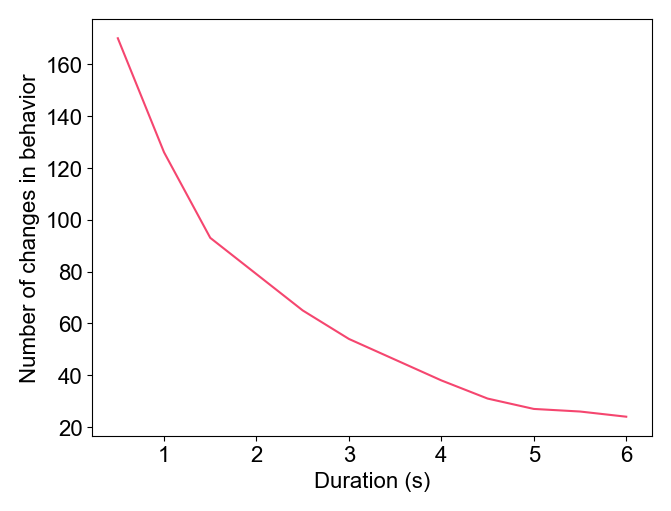

In [27]:

# plot function of change between set duration of behavioral state and number of changes in behavior for 1 RS session
fig, ax = plt.subplots()

ax.plot(DURATION_TIMES, instances, color="#F5466F")
ax.set_xlabel("Duration (s)")
ax.set_ylabel("Number of changes in behavior")
#ax.show()

In [ ]:

DURATION = 3 # in seconds 
differences = np.diff(wh)

epoch_times = np.array([])
for i in np.where(differences >= DURATION*30000)[0]:
    epoch_times = np.append(wh[i], epoch_times)

epoch_times = np.sort(epoch_times)
instances = np.concatenate((instances, epoch_times), axis=0)

#epoch_times
#print(f"Number of changes in behavioral states with {DURATION} seconds: {epoch_times.shape[0]}")
instances.shape
        

(779,)

### ***deprecated

In [ ]:
# downsample eye signals to fit LFP
downsample_factor = int(eye_signal.sampling_rate.magnitude / lfp_signal.sampling_rate.magnitude)
if downsample_factor == 60 :
    downsample_eye = eye_signal.downsample(downsample_factor)

True

In [ ]:
# define function for when creating the epoch object
def get_mean_state(diam):
    if np.sum(diam <= 0.5) > np.sum(diam > 0.5):
        state = 'Closed_eyes'
    else:
        state = 'Open_eyes'
    return state

In [ ]:
## create epoch object
wh = np.where(np.diff(behavioral_state) != 0)[0]
wh.shape
#start_time = wh - (duration/2)
# edgeindex = [0] + wh.tolist() + [len(behavioural_state)]

# # initialise with first slice
# i_start = [edgeindex[0]]
# i_stop = [edgeindex[1]]
# states = [get_mean_state(behavioural_state[edgeindex[0]:edgeindex[1]])]
# # Loop over indices, assign states and merge consecutive same-state slices
# for startidx, stopidx in zip(edgeindex[1:-1], edgeindex[2:]):
#     nextstate = get_mean_state(behavioural_state[startidx:stopidx])
#     if nextstate == states[-1]:
#         i_stop[-1] = stopidx
#     else:
#         i_start.append(startidx)
#         i_stop.append(stopidx)
#         states.append(nextstate)

# # Turn index lists into time arrays
# start_times = (np.array(i_start) / ydiam.sampling_rate).rescale('s')
# stop_times = (np.array(i_stop) / ydiam.sampling_rate).rescale('s')
# durs = stop_times - start_times

# # Convert into a pandas dataframe,
# datadict = {'t_start': start_times.magnitude,
#                 't_stop': stop_times.magnitude,
#                 'dur': durs.magnitude,
#                 'state': states}

# epochs = pd.DataFrame(data=datadict)

AnalogSignal with 1 channels of length 39627730; units V; datatype float64 
name: 'Behavioural state'
annotations: {'nix_name': 'neo.analogsignal.6dcd4242b0ad425ea2b787dbf5fc1357'}
sampling rate: 30000.0 Hz
time: 0.0 s to 1320.9243333333334 s